# 교차 검증과 그리드 서치

## 검증 세트 (Validation Set)

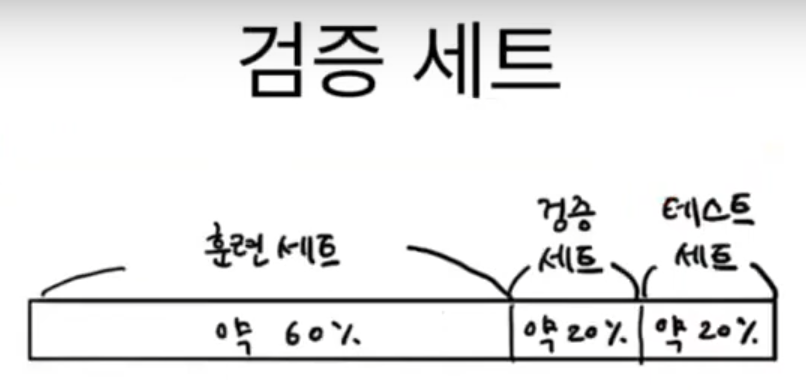
* 훈련세트: 모델을 학습하기 위한 데이터셋
* 검증세트: 모델을 검증하고 모델의 성능을 향상 시키기 위한 데이터셋
* 테스트세트: 운영환경에서 모델의 성능을 예측 및 평가하기 위한 데이터셋
* Best Practice
 - 훈련세트로 모델 학습
 - 검증세트로 파라메터 최적화
 - 훈련세트와 검증세트를 통합한 데이터로 최종 모델 학습
 - 테스트세트로 모델 최종 평가

In [5]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [6]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [7]:
from sklearn.model_selection import train_test_split

# test_input, test_target => 시험데이터셋
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [8]:
# sub_input, sub_target => 훈련데이터셋 / val_input, val_target => 검증데이터셋
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [9]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [10]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


# 모델 성능 향상 작업 : 훈련데이터셋, 검증데이터셋
- Feature Engineering
- Hyper Parmeter Tuning

## 최종 모델 성능 평가 : 테스트데이터셋
- print(dt.score(test_input, test_target))

## 교차 검증
- 데이터셋의 편중되는 것을 막기위해서 보다 객관적으로 테스트하기 위한 방법
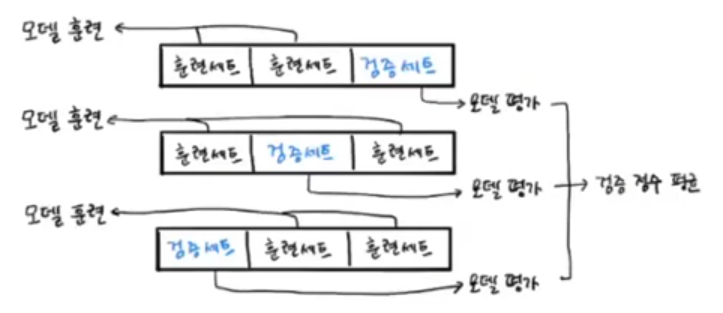

In [11]:
from sklearn.model_selection import cross_validate

# 교차검증 데이터셋은 기본값으로 5폴드를 사용함
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00600576, 0.00500464, 0.00500536, 0.00500464, 0.00500441]), 'score_time': array([0.        , 0.00100017, 0.00100017, 0.00100088, 0.0010016 ]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [12]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


## 교차 검증 적용 현황
* ML은 교차검증 선택적으로 적용 가능
* DL은 일반적으로 검증세트, 훈련세트로만 진행  
 => DL쪽 데이터는 이미 충분히 확보된 경우가 많고 비정형데이터를 검증하는데 N개 이상의 셋으로 진행하는 것이 비현실적일수 있기 때문

In [13]:
from sklearn.model_selection import StratifiedKFold

# 아래와 같이 호출하면 cv의 기본값은 5로 5분할로 진행 또는 분할 값을 설정할 수 있음(cv=10)
# scores = cross_validate(dt, train_input, train_target)

# 또는 아래와 같이 cv=스플리트객체 를 지정하여 보다 상세한 제어를 할 수 있음
# cross_validate에 사이킷런의 ML 모델객체를 인자로 넘겨주면 내부적으로 해당 모델이
# 선형 모델인지 분류 모델인지 인식하여 분류일 경우에는 KFold, 분류문제인 경우 StratifiedKFold 스틀리트 객체를 내부적으로 사용함
# StratifiedKFold객체는 훈련셋, 테스트셋에 분류클래스가 균등하게 입력되도록 자동분할을 함
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [14]:
# n_splits=10 => 10분할, shuffle=True => 데이터를 랜덤하게 섞음, random_state=42 => random seed 설정 
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝

In [26]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라메터를 딕셔너리 타입으로 정의
# min_impurity_decrease: 정보이득(부모와 자식노드간의 불순도의 차이) 최소값을 지정, 
#                        분할 시 지정한 정보이득 값보다도 작게 나온다면 분할을 하지 않도록 제어
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [27]:
# n_jobs CPU 코어가 여러개 일 경우 2이상의 값을 입력하여 튜닝작업을 병렬로 진행
# n_jobs 기본값은 1이며 -1로 설정시 모든 core를 사용
# 총 테스트 횟수: 10* 5 (앞에서 cross_validate로 10분할 * 하이퍼파라메터 min_impurity_decrease의 5가지 값)
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [28]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [29]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [30]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [31]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [32]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [37]:
# 각 모델별 주요 하이퍼파라메터와 범위를 참고하여 설정한다.
# 각각 파라메터의 최적값만 찾는 것이 아니라 모든 하이퍼파라메터의 조합까지 고려하여 최적의 파라메터를 찾는다.
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [35]:
# 아래와 같이 튜닝 조합의 강도를 조금만 올려줘도 조합의 갯수와 분석 시간은 기하급수적으로 늘어난다.
# params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
#           'max_depth': range(3, 50, 1),
#           'min_samples_split': range(2, 200, 1)
#           }

In [38]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
# 총 튜닝 횟수: 10 * 10 * 15 * 10 =15000
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [24]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [25]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치

In [1]:
# uniform, randint 실수/정수형 데이터에 대한 균등분포 샘플링
from scipy.stats import uniform, randint

In [24]:
# scipy.stats의 randint(0,10) => 0~10 수를 샘플링할 수 있는 객체 생성 (0포함, 10포함X)
rgen = randint(0, 10)
# rgen.rvs(N) N개의 샘플링 결과 제공
# ex) rgen.rvs(10) => 10개를 샘플링한 결과
rgen.rvs(10)

array([7, 3, 4, 1, 3, 0, 1, 1, 5, 9], dtype=int64)

In [25]:
# 1000개를 샘플링한 결과
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([ 97, 106, 108,  89, 106,  96, 108,  96,  86, 108], dtype=int64))

In [26]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.10723124, 0.78116759, 0.8649717 , 0.10439589, 0.54974532,
       0.30838615, 0.52533518, 0.51217225, 0.59681943, 0.52383483])

In [27]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# n_iter=100: 하이퍼파라메터의 샘플링(rvs) 조합을 100번까지 시도
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A2F4AAF8E0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A2F4A8FDC0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A2F4AAF670>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A2F4A141F0>},
                   random_state=42)

In [29]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [30]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [31]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86
